In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 13:28:26 2017

@author: jkunert
"""

import numpy as np
from DMD import DMD
import matplotlib as mpl
import matplotlib.pyplot as plt
import os,time,sys
import h5py
import scipy as sci
import scipy.spatial.distance as ssd
import parseCIFTI as pC
from glob import glob
import h5py
import copy
from hcp_dmd_utils import *
from tqdm import tqdm_notebook as tqdm
initR()
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
with h5py.File('./RSN.h5','r') as hf:
    RSNs=np.array(hf['RSNs'])
    RSNlabels=np.array(hf['RSNlabels'])

rsn=[]        
for k in range(RSNs.shape[2]):
    r=RSNs[:,:,k]
    rsn.append(mat2flat(r))
rsn=np.vstack(rsn)
rsnNo=np.arange(RSNs.shape[2])
rsnNo=np.delete(rsnNo,[0,7])
rsn=rsn[rsnNo,:]
rlabs=RSNlabels[rsnNo]

saveOn=True

dL,dR,idx,scb,scl=pC.parseCoords()
nSC=dL.shape[0]+dR.shape[0]
u120=np.genfromtxt('./u120.txt').astype(int).astype(str)
ulist=u120

scandirs=['LR','RL']
runlabels=['REST2','REST1']
runsets=[[32,171],[64,400],[8,32]]

In [41]:
cfl.split('/')[-1].split('.')[0].split('_')

['REST2', 'LR', '8m', '32f', '8clusters2']

In [42]:

import itertools
finefiles=glob('./DMD_Clusters/*.h5')

MODES=[]
MODU=[]

CMS=[]
W=[]
WINU=[]
WINJ=[]
FQ=[]
CSUBS=[]
nWindows=[]
for cfl in finefiles:
    print cfl
    runlabel,scandir,nmodes,nframes=cfl.split('/')[-1].split('.')[0].split('_')[:-1]
    nframes=int(nframes[:-1])
    nmodes=int(nmodes[:-1])

    freq=[]
    power=[]
    F=[]
    ux=[]
    jx=[]
    jno=[]
    rx=[]
    for uid,u in enumerate(ulist):
        fdir='./DMD_results/nmodes{:}_nframes{:}_{:}_{:}/'.format(nmodes,nframes,runlabel,scandir)
        try:
            with h5py.File(fdir+'Modes_{:}.h5'.format(u),'r') as hf:
                F.append(np.array(hf['F']))
            with h5py.File(fdir+'{:}.h5'.format(u),'r') as hf:            
                freq.append(np.array(hf['freq']))
                power.append(np.array(hf['power']))
                ux.append(np.array(hf['ux']))
                jx.append(np.array(hf['jx']))
                jno.append(np.array(hf['jno']))
        except:
            pass
    freq=np.hstack(freq)
    power=np.hstack(power)
    F=np.vstack(F)
    ux=np.hstack(ux).astype(int)
    jx=np.hstack(jx).astype(int)
    jno=np.hstack(jno).astype(int)
    winVals,winNo=np.unique(np.array(['{:03.0f}_{:03.0f}'.format(ux[k],jx[k]) for k in range(len(jx))]),return_inverse=True)
    winu,winj=np.vstack([np.array(wv.split('_')).astype(int) for wv in winVals]).T
    uidx=np.unique(ux,return_inverse=True)[1]

    with h5py.File(cfl,'r') as hf:
        clusters=np.array(hf['clusters'])
        
    modes=[]
    modu=np.zeros((len(clusters),120))
    for k,c in enumerate(clusters):
        modu[k,np.unique(ux[c]).astype(int)]=1
        modes.append(np.mean(F[c],0))
    modes=np.vstack(modes)
    
    MODES.append(modes)
    MODU.append(modu)
    
    #calculate where modes exist in same window and what coupling coefficients are
    windows=[]
    for k,c in enumerate(clusters):
        windows.append(np.unique(winNo[c]))
    CM=np.zeros([len(windows)]*2)
    for i in range(len(windows)):
        for j in range(len(windows)):
            shared_wins=np.intersect1d(windows[i],windows[j])
            CM[i,j]=len(shared_wins)
            CM[j,i]=len(shared_wins)                    
    CMS.append(CM)
    W.append(np.array(windows))
    WINU.append(winu)
    WINJ.append(winj)
    FQ.append([freq[c] for c in clusters])
    nWindows.append(winNo.max()+1)
    """
    from collections import Counter
    Nsub=len(np.unique(ux))
    Csub=np.zeros((Nsub,N))
    for k,ck in enumerate(trialsort[-1][:N]):
      c=np.vstack(Counter(ux[clusters[ck]]).items())
      Csub[c[:,0],k]=c[:,1]
    CSUBS.append(Csub)
    """
nbit=np.argmin([len(mj) for mj in MODES])
M=copy.copy(MODES)
MU=copy.copy(MODU)
m1=M.pop(nbit)
mu1=MU.pop(nbit)

ff=copy.copy(finefiles)
ff1=ff.pop(nbit)
ff=[ff1]+ff
fflab=['_'.join(f.split('/')[-1].split('_')[:2]) for f in ff]

CMlist=copy.copy(CMS)
cm1=CMlist.pop(nbit)



C=[]
for k,m2 in enumerate(M):
    c=1-ssd.cdist(m1,m2,metric='correlation')
    C.append(c.max(1))
C=np.vstack(C)
reposort=np.flipud(np.argsort(C.prod(0)))

m1=m1[reposort]

C=[]
CIX=[]
Msort=[]
MUsort=[]
CMsort=[]
for k,m2 in enumerate(M):
    c=1-ssd.cdist(m1,m2,metric='correlation')
    C.append(c.max(1))
    #just taking the argmax:
    cix=[]
    invalid=np.zeros(c.shape[1]).astype(bool)
    for r,cr in enumerate(c):
        cr[invalid]=0
        cir=np.argmax(cr)
        invalid[cir]=True
        cix.append(cir)
    cix=np.array(cix)

    CIX.append(cix)
    Msort.append(m2[cix])
    MUsort.append(MU[k][cix,:])
    
    CMsort.append(CMlist[k][cix,:][:,cix])

C=np.vstack(C)

Msort=[m1]+Msort
Msort=np.dstack(Msort)
MUsort=[mu1]+MUsort
MUsort=np.dstack(MUsort)
CMsort=[cm1]+CMsort
CMsort=np.dstack(CMsort)
cp=np.flipud(np.sort(C.prod(0)))

#%
nord=-1
trialsort=[]
for k in range(4):
    if k==nbit:
        trialsort.append(reposort)
    else:
        nord+=1
        trialsort.append(CIX[nord])

#%

N=6

./DMD_Clusters/REST2_LR_8m_32f_8clusters2.h5
./DMD_Clusters/REST1_RL_8m_32f_8clusters2.h5
./DMD_Clusters/REST2_RL_8m_32f_10clusters2.h5
./DMD_Clusters/REST1_LR_8m_32f_9clusters2.h5


In [43]:
TS=[]
for run in range(4):
    Ts=[]
    for uid in range(len(ulist)):
        #loop through different cluster numbers, return matrix showing occurence of each cluster in individual's windows
        WIX=[]
        T=np.zeros((N,jx.max()+1))
        for n in range(N):
            #get window numbers corresponding to run & cluster number
            wix=W[run][trialsort[run]][n]
            #narrow down to single individual 'uid'
            wix=wix[WINU[run][wix]==uid]
            #convert from absolute indices to inter-run indices
            wix=WINJ[run][wix]
            T[n,wix]=1
        Ts.append(T)
    TS.append(np.stack(Ts))
TS=np.stack(TS)


In [44]:
#%%
run=0
#mode number
n=0
#window shift
Mdt=[]
for dt in range(40):
    Ms=[]
    for uid in range(len(ulist)):
        tu=TS[run,uid][:,:(293-dt)]
        M=[]
        for k in range(N):
            #indices where mode is on
            non=np.where(tu[k])[0]
            if len(non)>0:
                M.append(np.sum(TS[run,uid][:,non+dt],1))
            else:
                M.append(np.zeros((1,N)))
        Ms.append(np.vstack(M))
    Mdt.append(np.stack(Ms))
Mdt=np.stack(Mdt)
#tu=np.vstack([np.sum(tu[:,np.where(tu[k])[0]+dt],1) for k in range(N)])

In [45]:
def occMat(run,N=6):
    return CMS[run][:,trialsort[run]][trialsort[run],:][:N,:N]

def transMat(run,dt,N=6):
    Ms=[]
    for uid in range(len(ulist)):
        tu=TS[run,uid][:,:(293-dt)]
        M=[]
        for k in range(N):
            #indices where mode is on
            non=np.where(tu[k])[0]
            if len(non)>0:
                M.append(np.sum(TS[run,uid][:,non+dt],1))
            else:
                M.append(np.zeros((1,N)))
        Ms.append(np.vstack(M))
    return np.sum(np.stack(Ms),0)/np.diag(occMat(run,N=N))[:,None]

([], <a list of 0 Text yticklabel objects>)

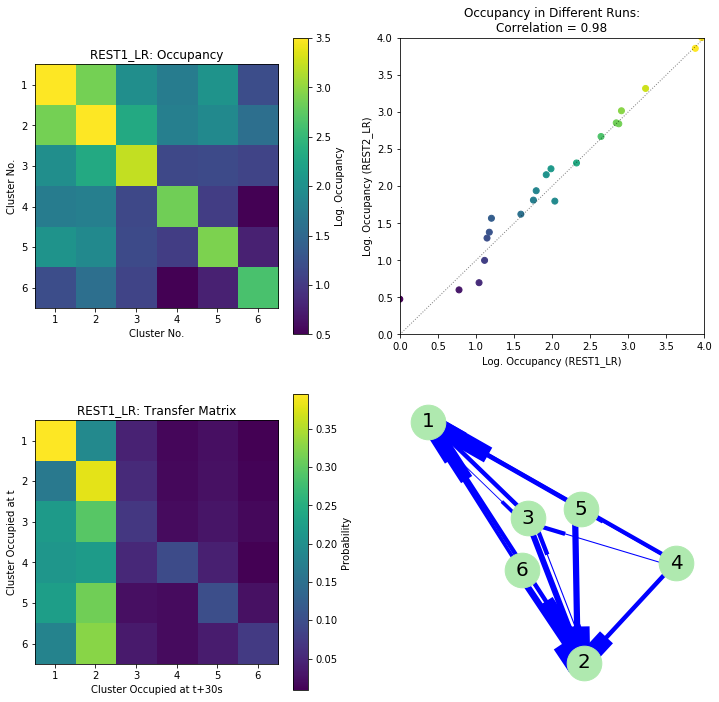

In [55]:
frame_shift=4
tstep=(14*60+33.)/1200*frame_shift
plt.figure(figsize=(12,12))
N=6
ffl=['_'.join(f.split('/')[-1].split('_')[:2]) for f in finefiles]

plt.subplot(2,2,1)
n=3
plt.title('{:}: Occupancy'.format(ffl[n]))
occ=occMat(n)
plt.imshow(np.log10(occ),vmin=0.5,vmax=3.5)
plt.colorbar(label='Log. Occupancy')
plt.xticks(np.arange(N),np.arange(1,N+1))
plt.yticks(np.arange(N),np.arange(1,N+1))
plt.xlabel('Cluster No.');plt.ylabel('Cluster No.')

plt.subplot(2,2,2)
i=3;j=0;
occ1=np.log10(occMat(i)[np.triu_indices(N)])
occ2=np.log10(occMat(j)[np.triu_indices(N)])
plt.plot([0,4],[0,4],':',c=[0,0,0,0.5],lw=1)
plt.scatter(occ1,occ2,c=(occ1+occ2)/2.0,cmap='viridis',vmin=0.5,vmax=3.5)
plt.xlabel('Log. Occupancy ({:})'.format(ffl[i]));
plt.ylabel('Log. Occupancy ({:})'.format(ffl[j]));
plt.xlim([0,4]);plt.ylim([0,4])
plt.title('Occupancy in Different Runs:\nCorrelation = {:0.2f}'.format(np.corrcoef(occ1,occ2)[0][1]))

Tmat=transMat(n,dt)
plt.subplot(2,2,3)
dt=int(30./tstep)
plt.imshow(Tmat)
plt.ylabel('Cluster Occupied at t')
plt.xlabel('Cluster Occupied at t+30s')
plt.title('{:}: Transfer Matrix'.format(ffl[n]))
plt.colorbar(label='Probability')
plt.xticks(np.arange(N),np.arange(1,N+1))
plt.yticks(np.arange(N),np.arange(1,N+1))

import networkx as nx
G=nx.DiGraph()
edgelist=[]
edgeweight=[]
for i in range(N):
    for j in range(N):
        if i!=j:
            edgelist.append((i+1,j+1))
            edgeweight.append(Tmat[i,j])
G.add_edges_from(edgelist)
elist=[(u,v) for (u,v,d) in G.edges(data=True)]
pos=nx.spring_layout(G)
ag=plt.subplot(2,2,4,frameon=False)
nx.draw_networkx_nodes(G,pos,with_labels=True,ax=ag,node_size=1200,node_color=[175./255,233./255,175./255])
for k,e in enumerate(edgelist):
    eweight=edgeweight[k]
    if eweight>0.04:
        #print '({:},{:}):{:}'.format(e[0],e[1],eweight)
        pose=copy.deepcopy(pos)
        shift=np.random.randn(2)*0.01
        pose[e[0]]+=shift
        pose[e[1]]+=shift
        nx.draw_networkx_edges(G,pose,edgelist=[(e[0],e[1])],width=20*eweight,alpha=1.0,edge_color='b',arrows=True)
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif',ha='center',va='center')
plt.xticks([]);plt.yticks([])